# Multilevel Monte Carlo Path Simulation

In [1]:
import sys, os
from time import perf_counter

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../py_mlmc")
from contract import Contract, EuropeanCall, AsianCall, Lookback, Digital
from mlmc import MLMC
from model import Model, BlackScholes, Heston
from utility import NormalGenerator

In [2]:
# Models
interest_rate = 0.05
initial_value = np.array([1.0])
sigma = 0.2

bs = BlackScholes(interest_rate, initial_value, sigma)

lbd, xi, rho = 5.0, 0.25, -0.5
initial_value = np.array([1.0, 0.04])
heston = Heston(interest_rate, initial_value, sigma, lbd, xi, rho)

# Contracts
maturity = 1.0
strike = 1.0

eu_call = EuropeanCall(maturity, strike)
asian_call = AsianCall(maturity, strike)
lookback = Lookback(maturity, sigma)
digital = Digital(maturity)

In [5]:
def create_paper_plots(mlmc: MLMC, model: Model, contract: Contract, target_errors: np.ndarray) -> None:
    print(f"========================== Model: {model.name()} - Contract: {contract.name()} ==========================")

    m = mlmc.m
    sample_count, level = 4 * 10**6, 5

    print("Computations for estimation of mean and variance...")
    t1 = perf_counter()
    estimator = mlmc.computations_for_plots(model, contract, sample_count, level)
    t2 = perf_counter()
    print(f"Took {t2 - t1}s")

    log_means = np.log(np.cumsum(estimator["means"])) / np.log(m)
    log_means_diff = np.log(estimator["means"][1:]) / np.log(m)
    log_vars = np.log(np.cumsum(estimator["vars"])) / np.log(m)
    log_vars_diff = np.log(estimator["vars"][1:]) / np.log(m)
    log_means_richardson = np.log(estimator["means_richardson"]) / np.log(m)

    optimals_samples = []
    optimals_samples_richardson = []
    computationnal_costs = []
    computationnal_costs_richardson = []
    computationnal_costs_std = []
    computationnal_costs_richardson_std = []
    for target_error in target_errors:
        print(f"--- Target error: {target_error} ---")

        print("Computing mlmc estimator without richardson extrapolation")
        t1 = perf_counter()
        estimator, samples = mlmc.compute_multilevel_estimator(model, contract, target_error, False)
        t2 = perf_counter()
        print(f"Took {t2 - t1}s")
        optimals_samples.append(samples)

        print("Computing mlmc estimator with richardson extrapolation")
        t1 = perf_counter()
        estimator_richardson, samples_richardson = mlmc.compute_multilevel_estimator(
            model, contract, target_error, True
        )
        t2 = perf_counter()
        print(f"Took {t2 - t1}s")
        optimals_samples_richardson.append(samples_richardson)

        costs = [samples[0]] + [samples[i] * (m**i + m ** (i - 1)) for i in range(1, len(samples))]
        computationnal_costs.append(np.sum(costs))
        costs_richardson = [samples_richardson[0]] + [
            samples_richardson[i] * (m**i + m ** (i - 1)) for i in range(1, len(samples_richardson))
        ]
        computationnal_costs_richardson.append(np.sum(costs_richardson))

        print("Computing standard estimator without richardson extrapolation")
        # t1 = perf_counter()
        # _, samples_std = mlmc.compute_standard_estimator(model, contract, target_error, False)
        # t2 = perf_counter()
        # print(f"Took {t2 - t1}s")
        # computationnal_costs_std.append(np.sum([s * m**i for i, s in enumerate(samples_std)]))
        # HACK: This calculation looks very close to the paper results, with instantaneous computation
        # uncomment the above lines to compute the standard estimator.
        vars = np.cumsum(estimator["vars"])
        computationnal_costs_std.append(np.sum([2 * v / target_error**2 * m**i for i, v in enumerate(vars)]))

        print("Computing standard estimator with richardson extrapolation")
        # t1 = perf_counter()
        # _, samples_std_richardson = mlmc.compute_standard_estimator(model, contract, target_error, True)
        # t2 = perf_counter()
        # print(f"Took {t2 - t1}s")
        # computationnal_costs_richardson_std.append(np.sum([s * m**i for i, s in enumerate(samples_std_richardson)]))
        # HACK: This calculation looks very close to the paper results, with instantaneous computation
        # uncomment the above lines to compute the standard estimator.
        vars = np.cumsum(estimator_richardson["vars"])
        computationnal_costs_richardson_std.append(np.sum([2 * v / target_error**2 * m**i for i, v in enumerate(vars)]))
        print()

    epsilon_cost = np.array(computationnal_costs) * target_errors**2
    epsilon_cost_richardson = np.array(computationnal_costs_richardson) * target_errors**2
    epsilon_cost_std = np.array(computationnal_costs_std) * target_errors**2
    epsilon_cost_richardson_std = np.array(computationnal_costs_richardson_std) * target_errors**2

    fig, axs = plt.subplots(2, 2, figsize=(14, 12), dpi=200)
    l1 = np.arange(0, level)
    l2 = np.arange(1, level)
    l3 = np.arange(2, level)

    # Top left
    axs[0, 0].plot(l1, log_vars, "-", marker="x", c="black", label="$P_l$")
    axs[0, 0].plot(l2, log_vars_diff, "--", marker="x", c="black", label="$P_l-P_{l-1}$")
    axs[0, 0].set_xlabel("l")
    axs[0, 0].set_xticks(np.arange(level))
    axs[0, 0].set_ylabel("$log_M$ variance")
    axs[0, 0].grid(which="major", linestyle="--", alpha=0.8)
    axs[0, 0].legend()

    # Top right
    axs[0, 1].plot(l1, log_means, "-", marker="x", c="black", label="$P_l$")
    axs[0, 1].plot(l2, log_means_diff, "--", marker="x", c="black", label="$P_l-P_{l-1}$")
    axs[0, 1].plot(l3, log_means_richardson[1:], "-.", marker="x", c="black", label="$Y_l-Y_{l-1}/M$")
    axs[0, 1].set_xlabel("$l$")
    axs[0, 1].set_xticks(np.arange(level))
    axs[0, 1].set_ylabel("$log_M |mean|$")
    axs[0, 1].grid(which="major", linestyle="--", alpha=0.8)
    axs[0, 1].legend()

    # Bottom left
    markers = ["o", "x", "v", "*", "s"]
    level_max = 0
    for i, optimal_samples in enumerate(optimals_samples):
        l = np.arange(len(optimal_samples))
        level_max = max(level_max, len(optimal_samples))
        target_error = f"{target_errors[-(i + 1)]:.5f}".rstrip("0")
        axs[1, 0].plot(l, optimal_samples, ":", marker=markers[i], c="black", label=rf"$\epsilon = {target_error}$")

    for i, optimal_samples in enumerate(optimals_samples_richardson):
        l = np.arange(len(optimal_samples))
        axs[1, 0].plot(l, optimal_samples, "-.", marker=markers[i], c="black")

    axs[1, 0].set_xlabel("$l$")
    axs[1, 0].set_xticks(np.arange(level_max))
    axs[1, 0].set_yscale("log")
    axs[1, 0].set_ylabel("$N_l$")
    axs[1, 0].grid(which="major", linestyle="--", alpha=0.8)
    axs[1, 0].legend()

    # Bottom right
    axs[1, 1].plot(target_errors, epsilon_cost, "--", c="black", marker="x", label="MLMC")
    axs[1, 1].plot(target_errors, epsilon_cost_richardson, "-.", c="black", marker="x", label="MLMC ext")
    axs[1, 1].plot(target_errors, epsilon_cost_std, ":", c="black", marker="x", label="Std MC")
    axs[1, 1].plot(
        target_errors, epsilon_cost_richardson_std, color="black", linestyle="-", marker="x", label="Std MC ext"
    )

    axs[1, 1].set_xscale("log")
    axs[1, 1].set_yscale("log")
    axs[1, 1].set_ylabel(r"$\epsilon^2$cost")
    axs[1, 1].set_xlabel(r"$\epsilon$")
    axs[1, 1].grid(which="major", linestyle="--", alpha=0.8)
    axs[1, 1].legend()

    # fig.tight_layout()
    fig.suptitle(f"{contract.name()} - {model.name()}")
    return fig, axs

In [4]:
# MLMC parameters
max_level = 5
default_sample_count = 10_000
m = 4
verbose = False

# For reproducibility
rng = np.random.default_rng(seed=42)

create_file = not os.path.exists("gaussian_buffer.dat")
gg = NormalGenerator(buffer_size=int(1.5e9), rng=rng, create_file=create_file, verbose=verbose)

mlmc = MLMC(max_level, m, default_sample_count, gg, verbose=verbose)

========================== Model: Black-Scholes - Contract: European Call ==========================
--- Target error: 0.001 ---
Computing mlmc estimator without richardson extrapolation
Took 0.015148083912208676s
Computing mlmc estimator with richardson extrapolation
Took 0.009999167174100876s
Computing standard estimator without richardson extrapolation
Computing standard estimator with richardson extrapolation

--- Target error: 0.0005 ---
Computing mlmc estimator without richardson extrapolation
Took 0.05506850010715425s
Computing mlmc estimator with richardson extrapolation
Took 0.02407433302141726s
Computing standard estimator without richardson extrapolation
Computing standard estimator with richardson extrapolation

--- Target error: 0.0002 ---
Computing mlmc estimator without richardson extrapolation
Took 0.06571345799602568s
Computing mlmc estimator with richardson extrapolation
Took 0.03860895894467831s
Computing standard estimator without richardson extrapolation
Computing 

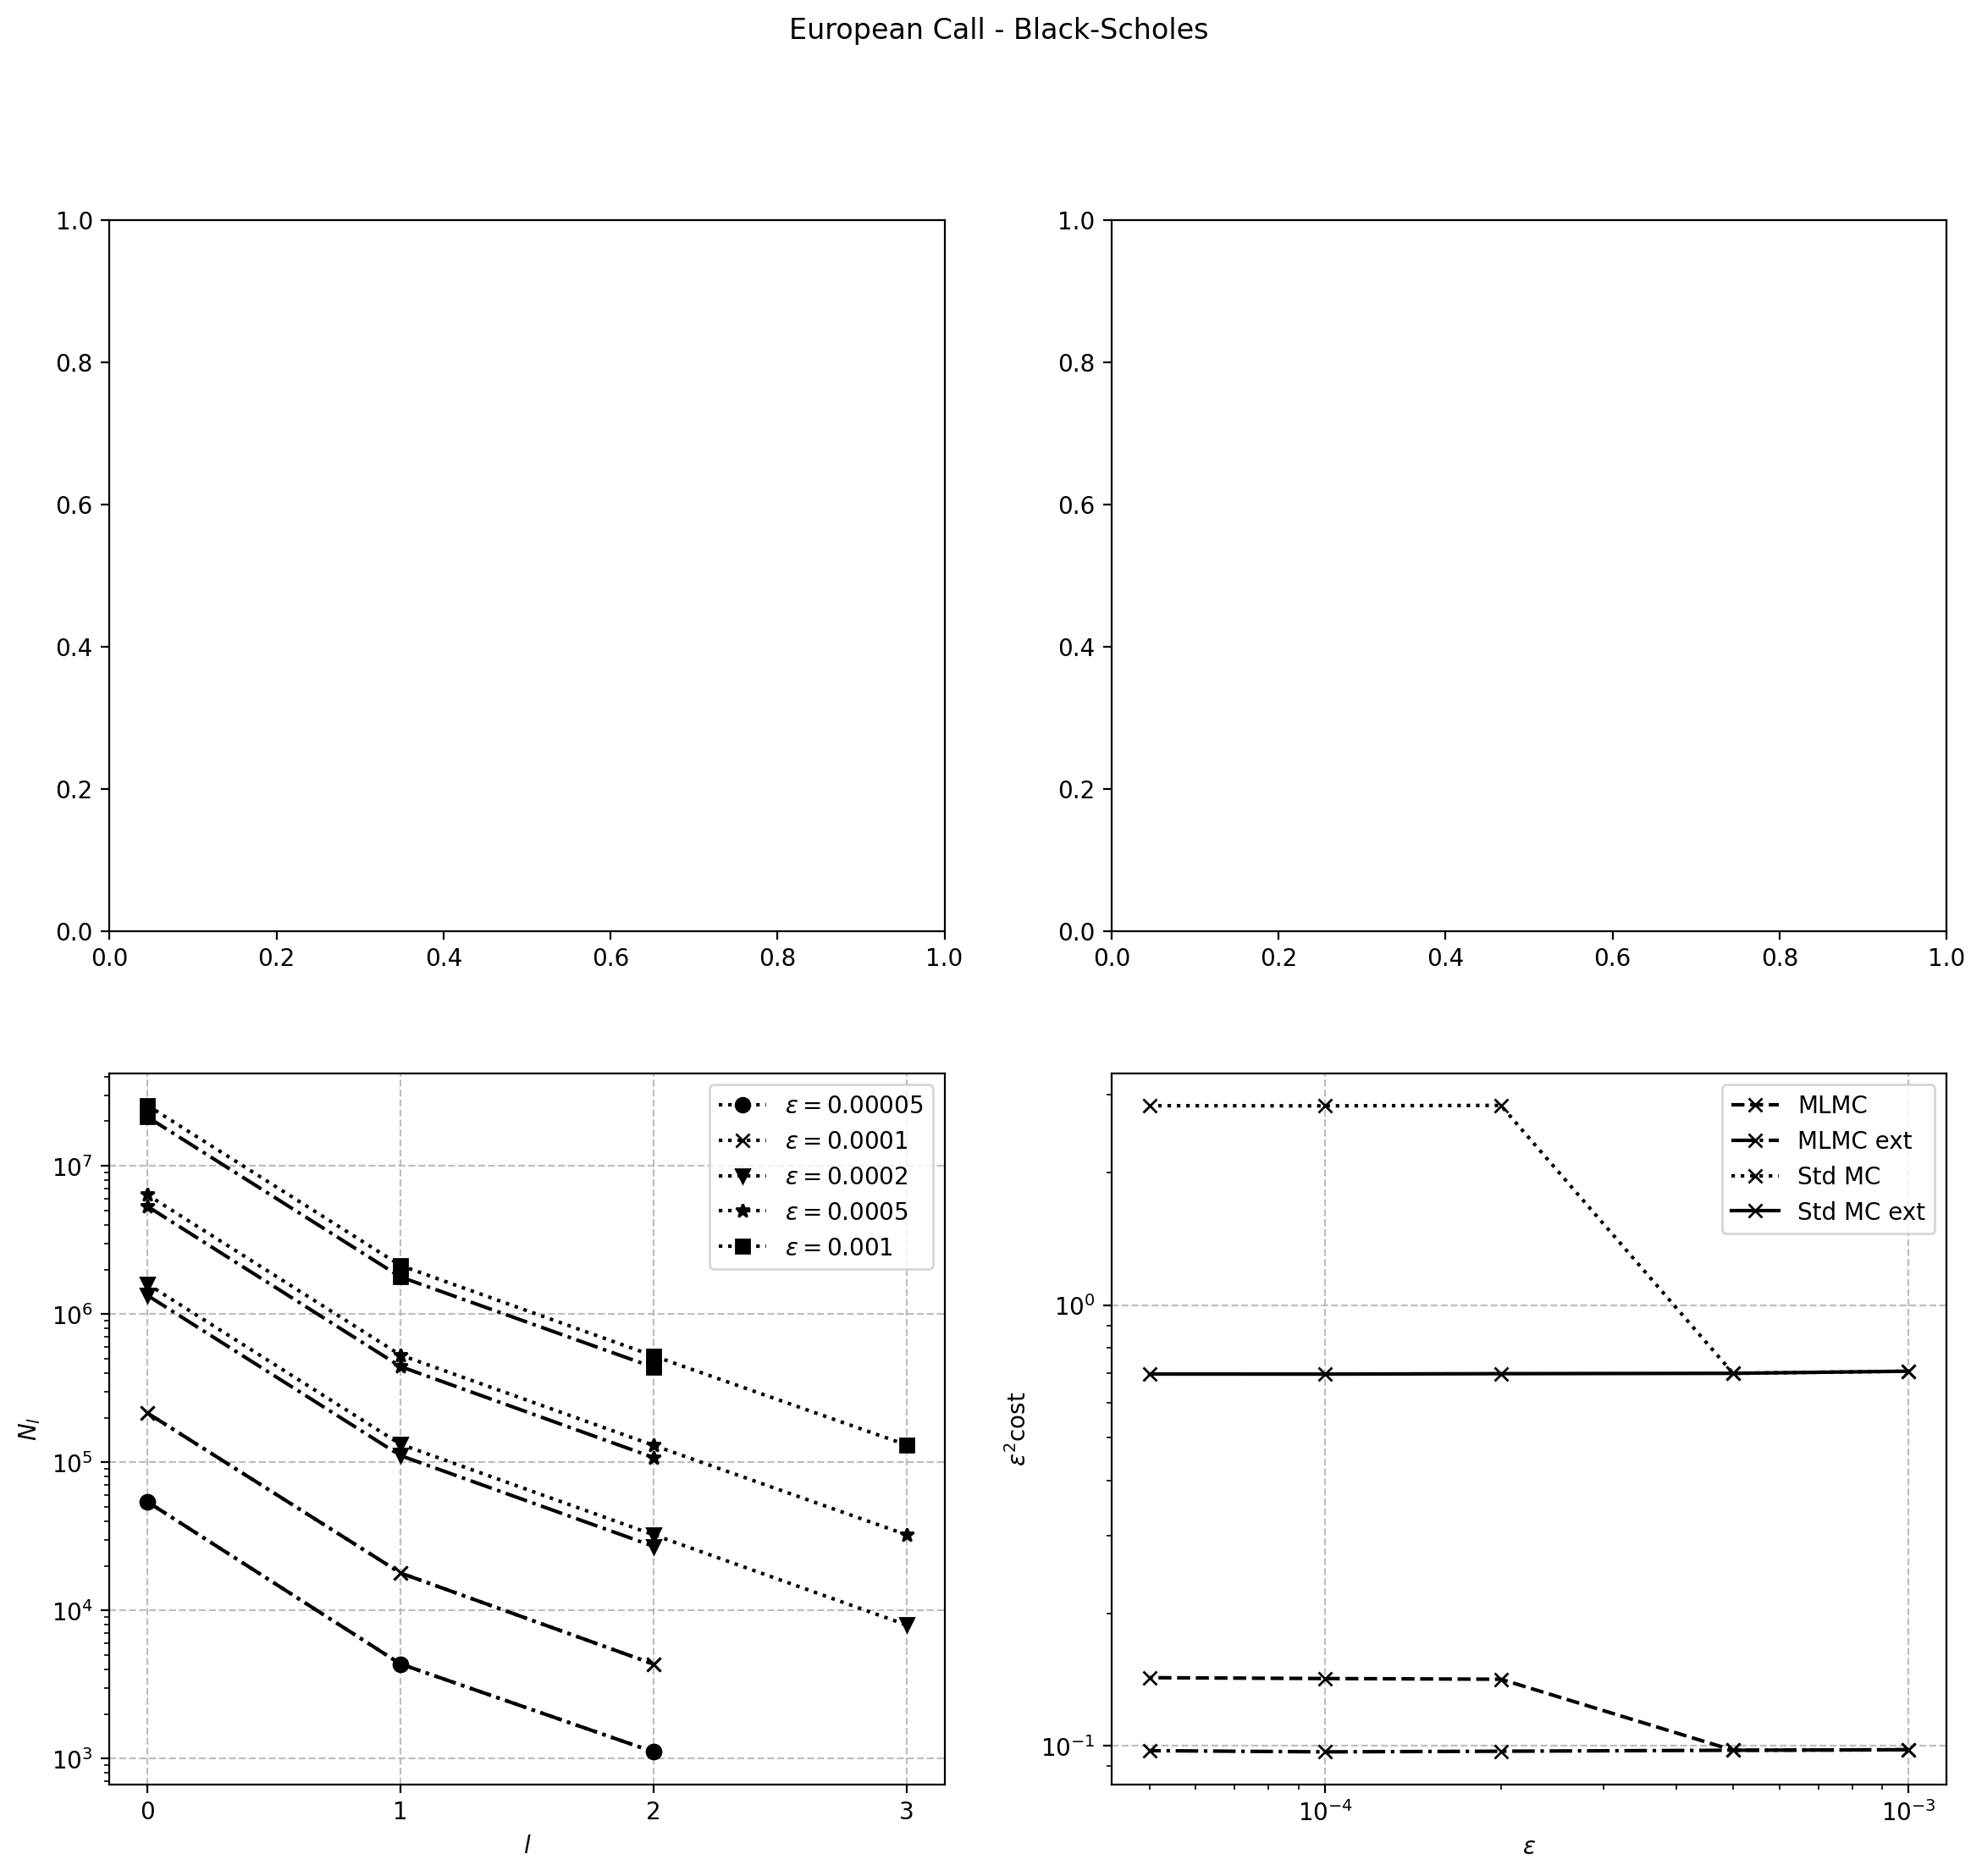

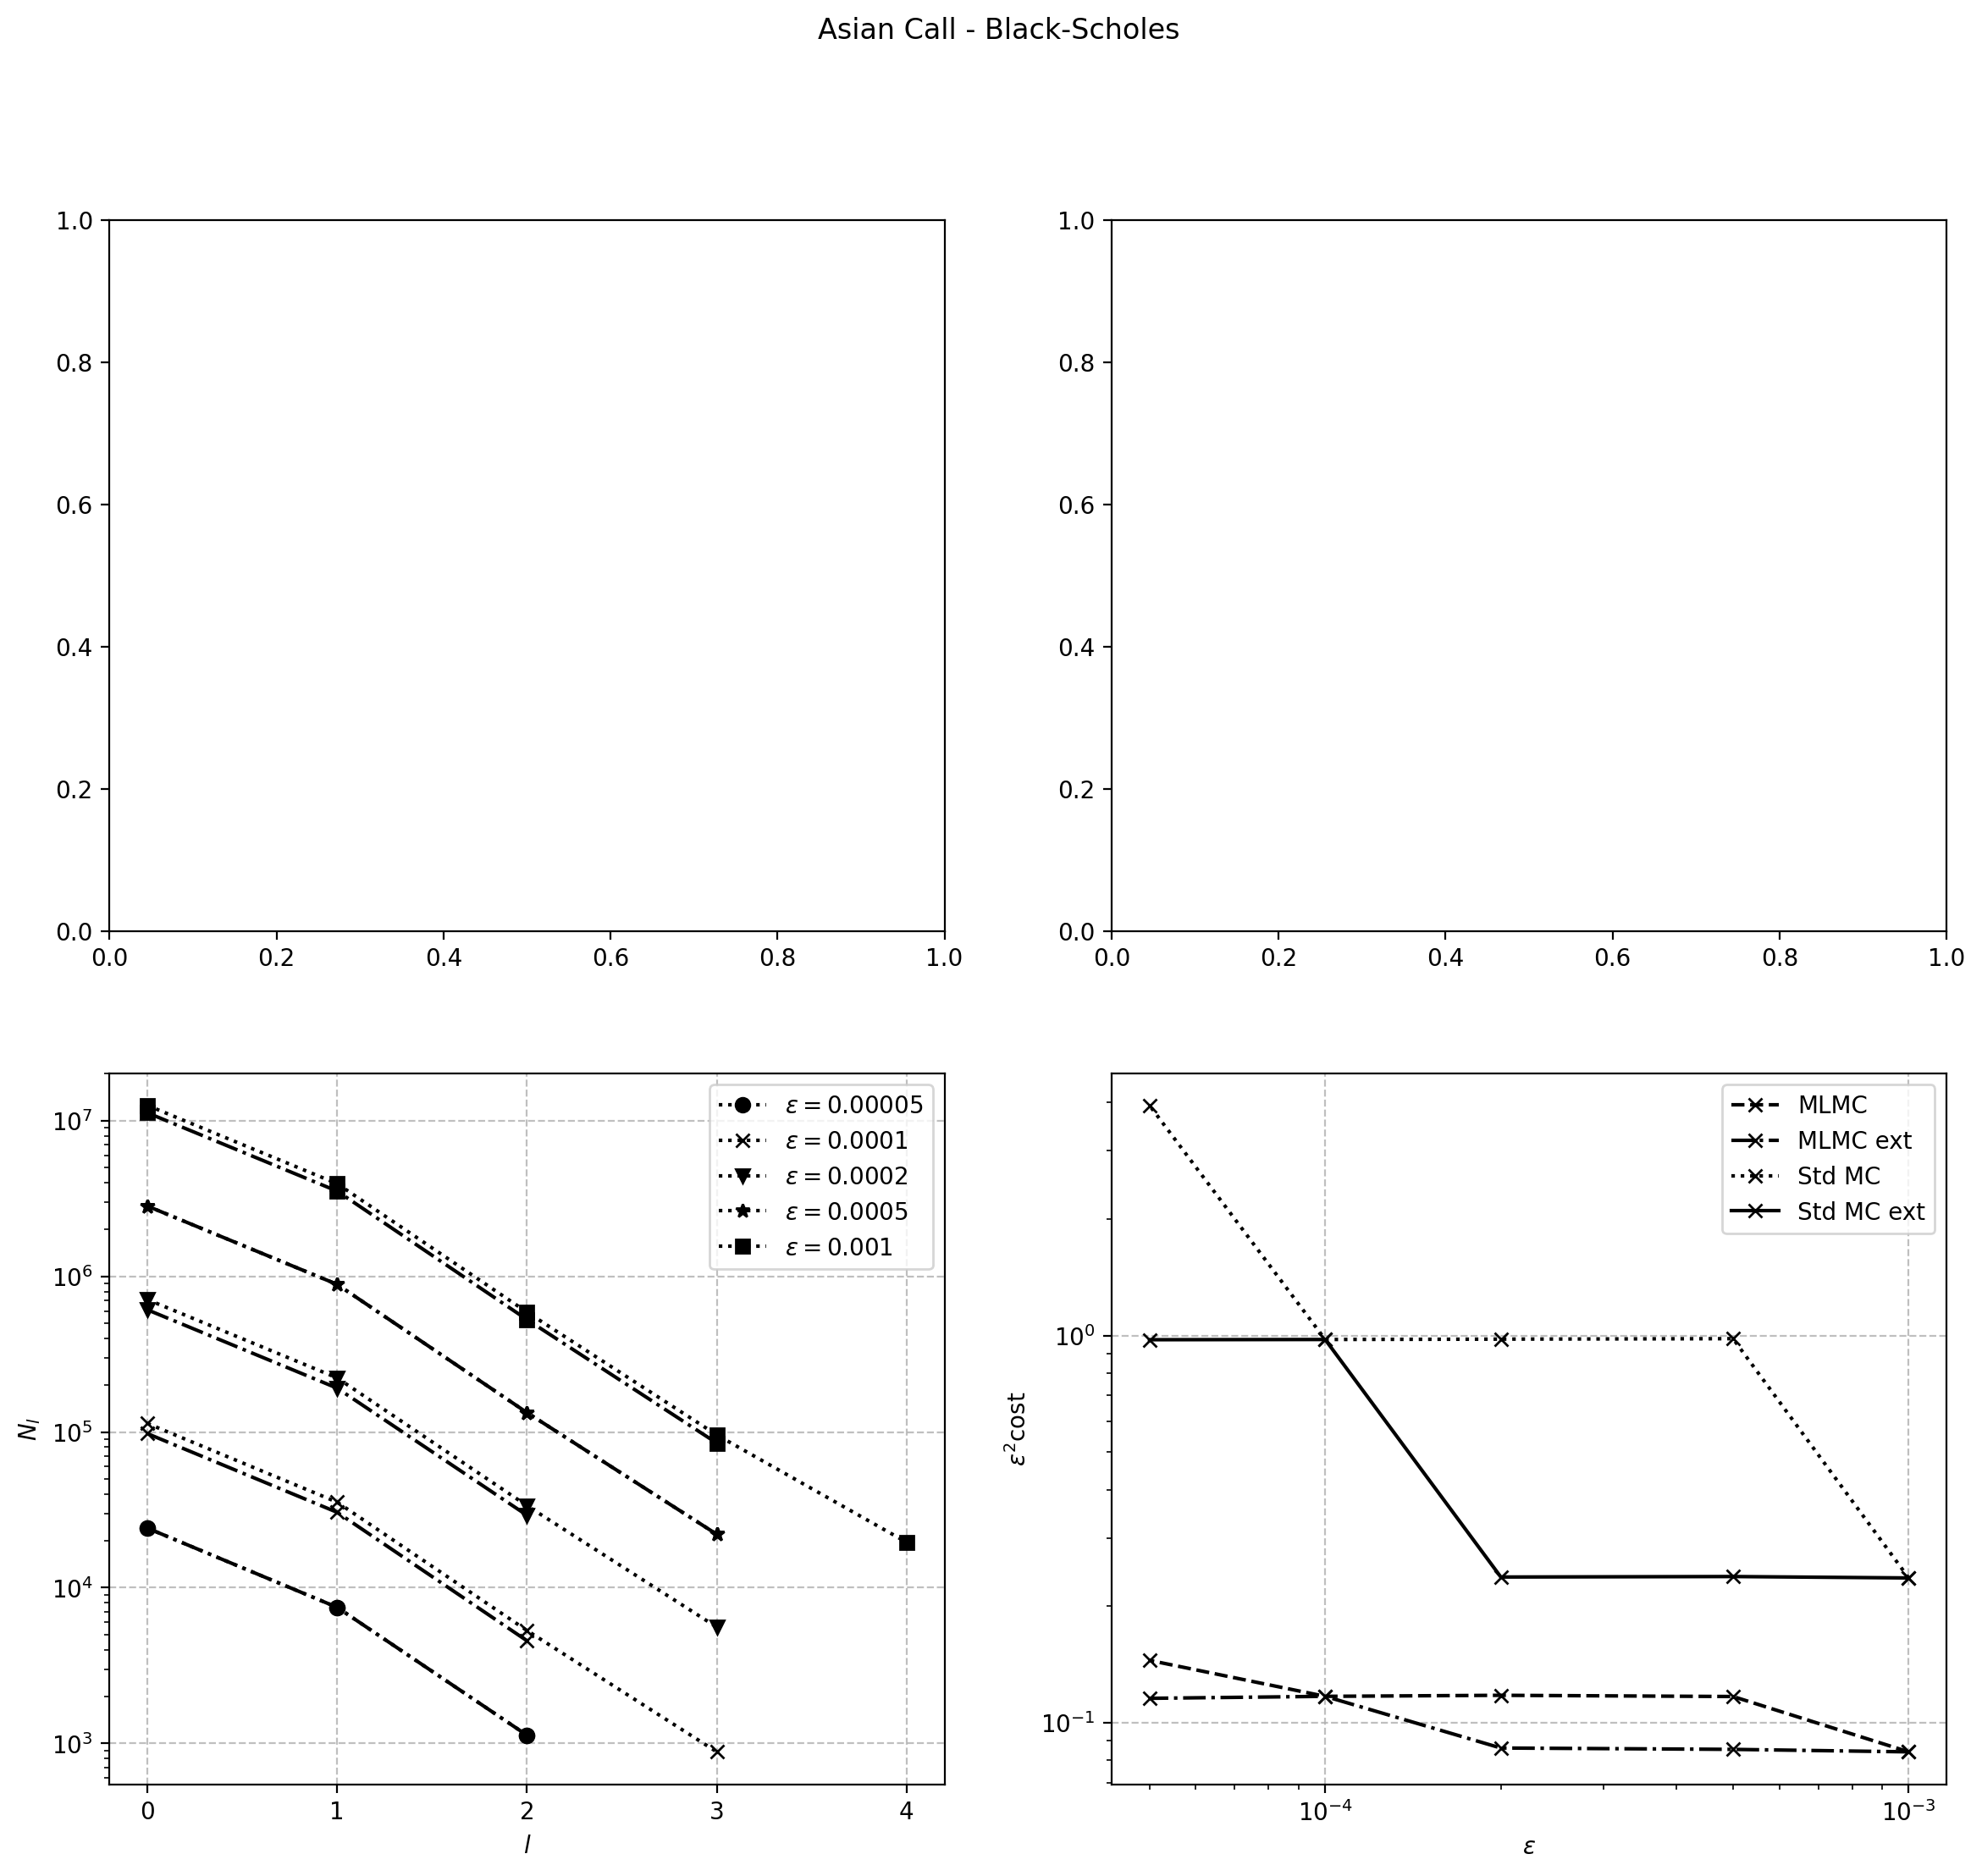

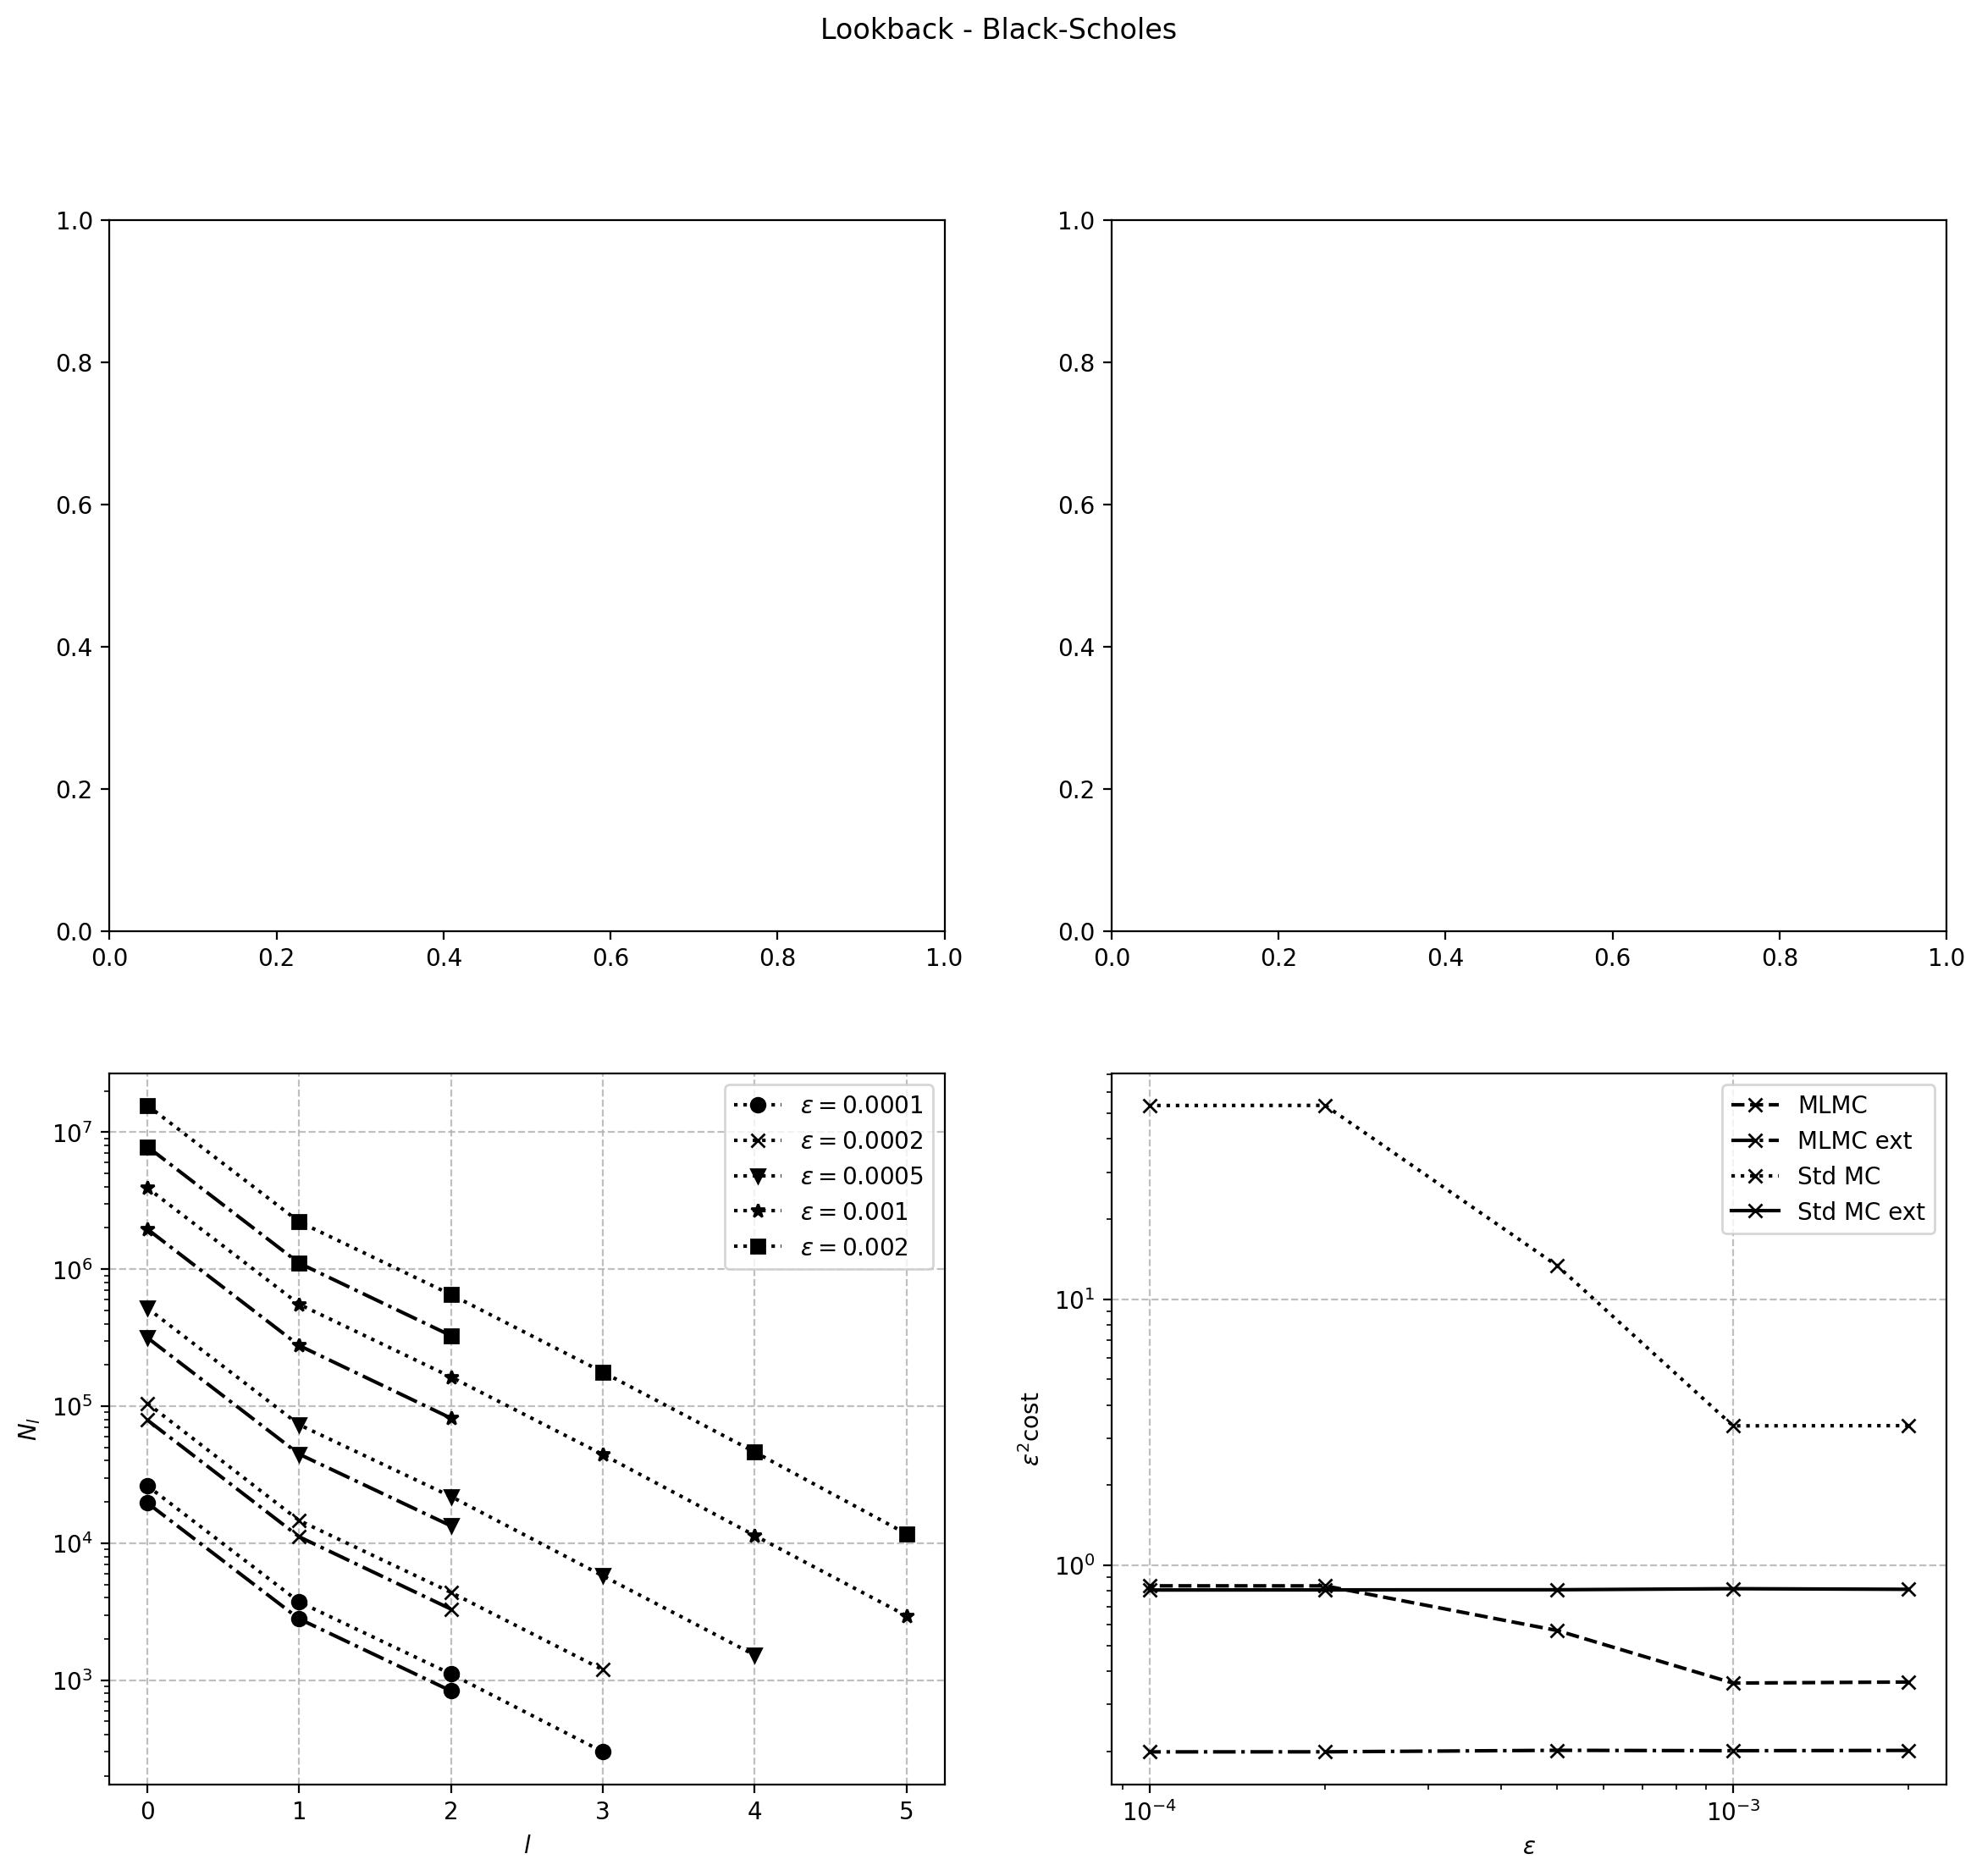

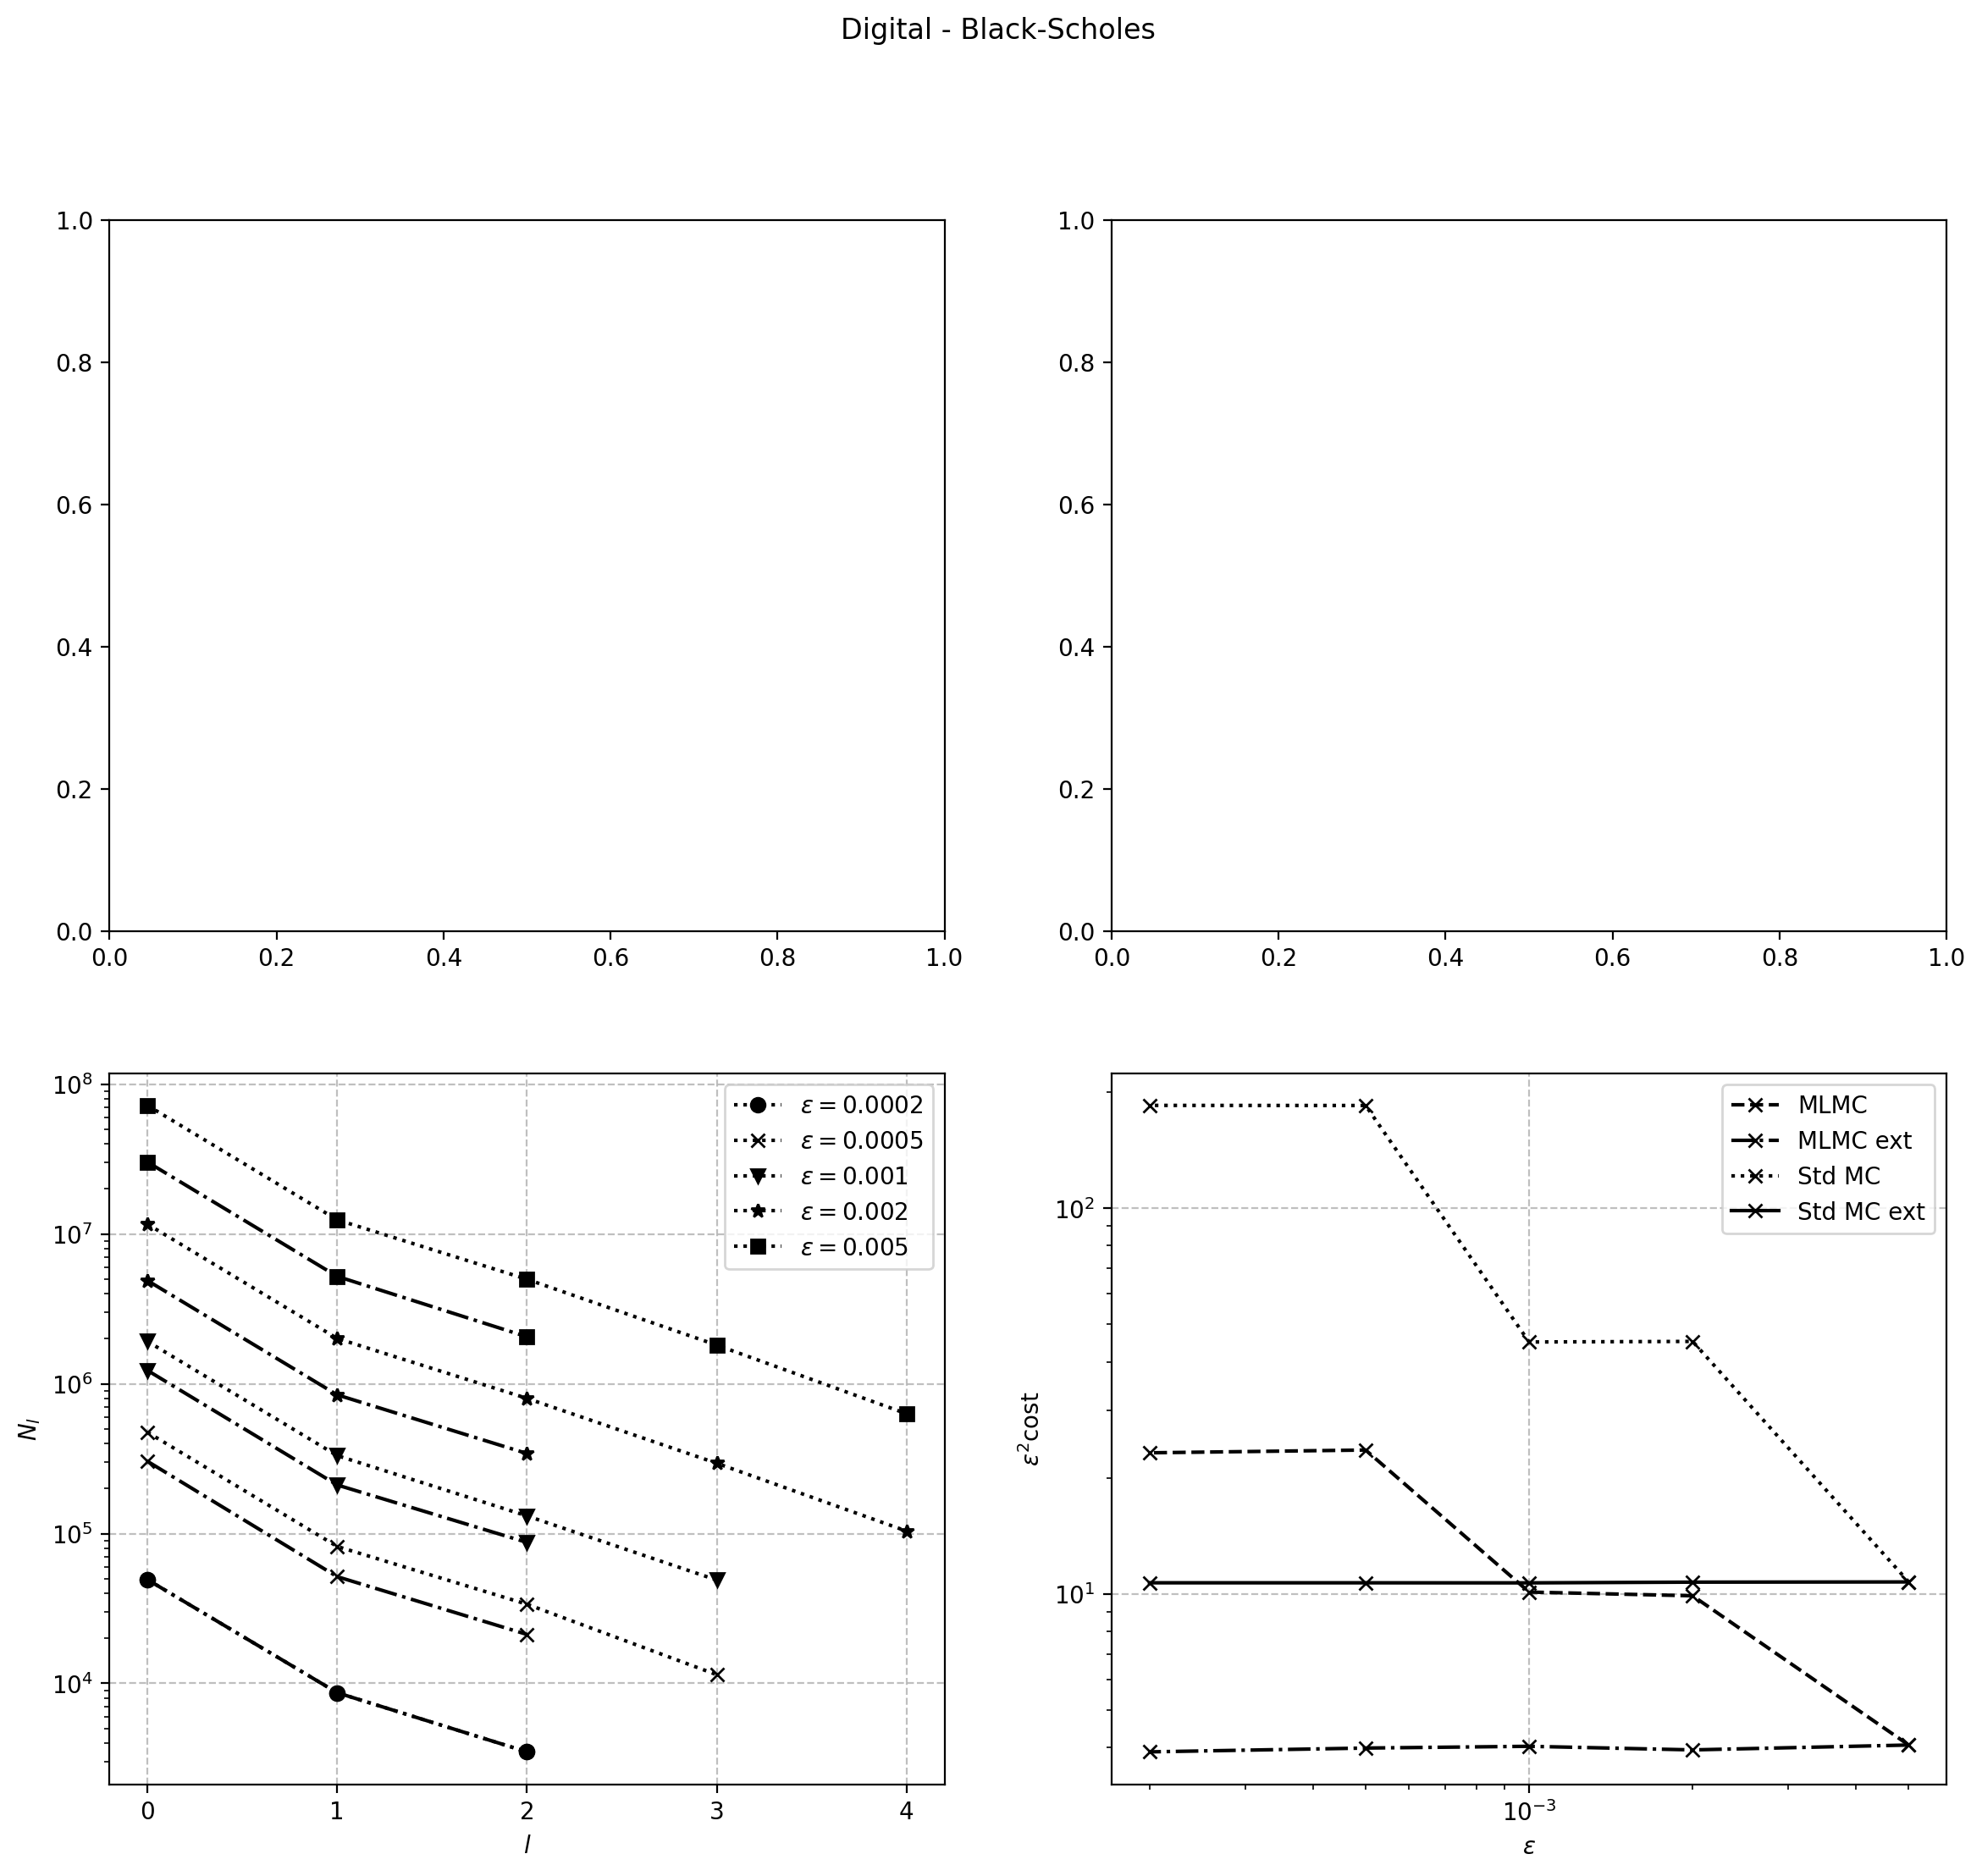

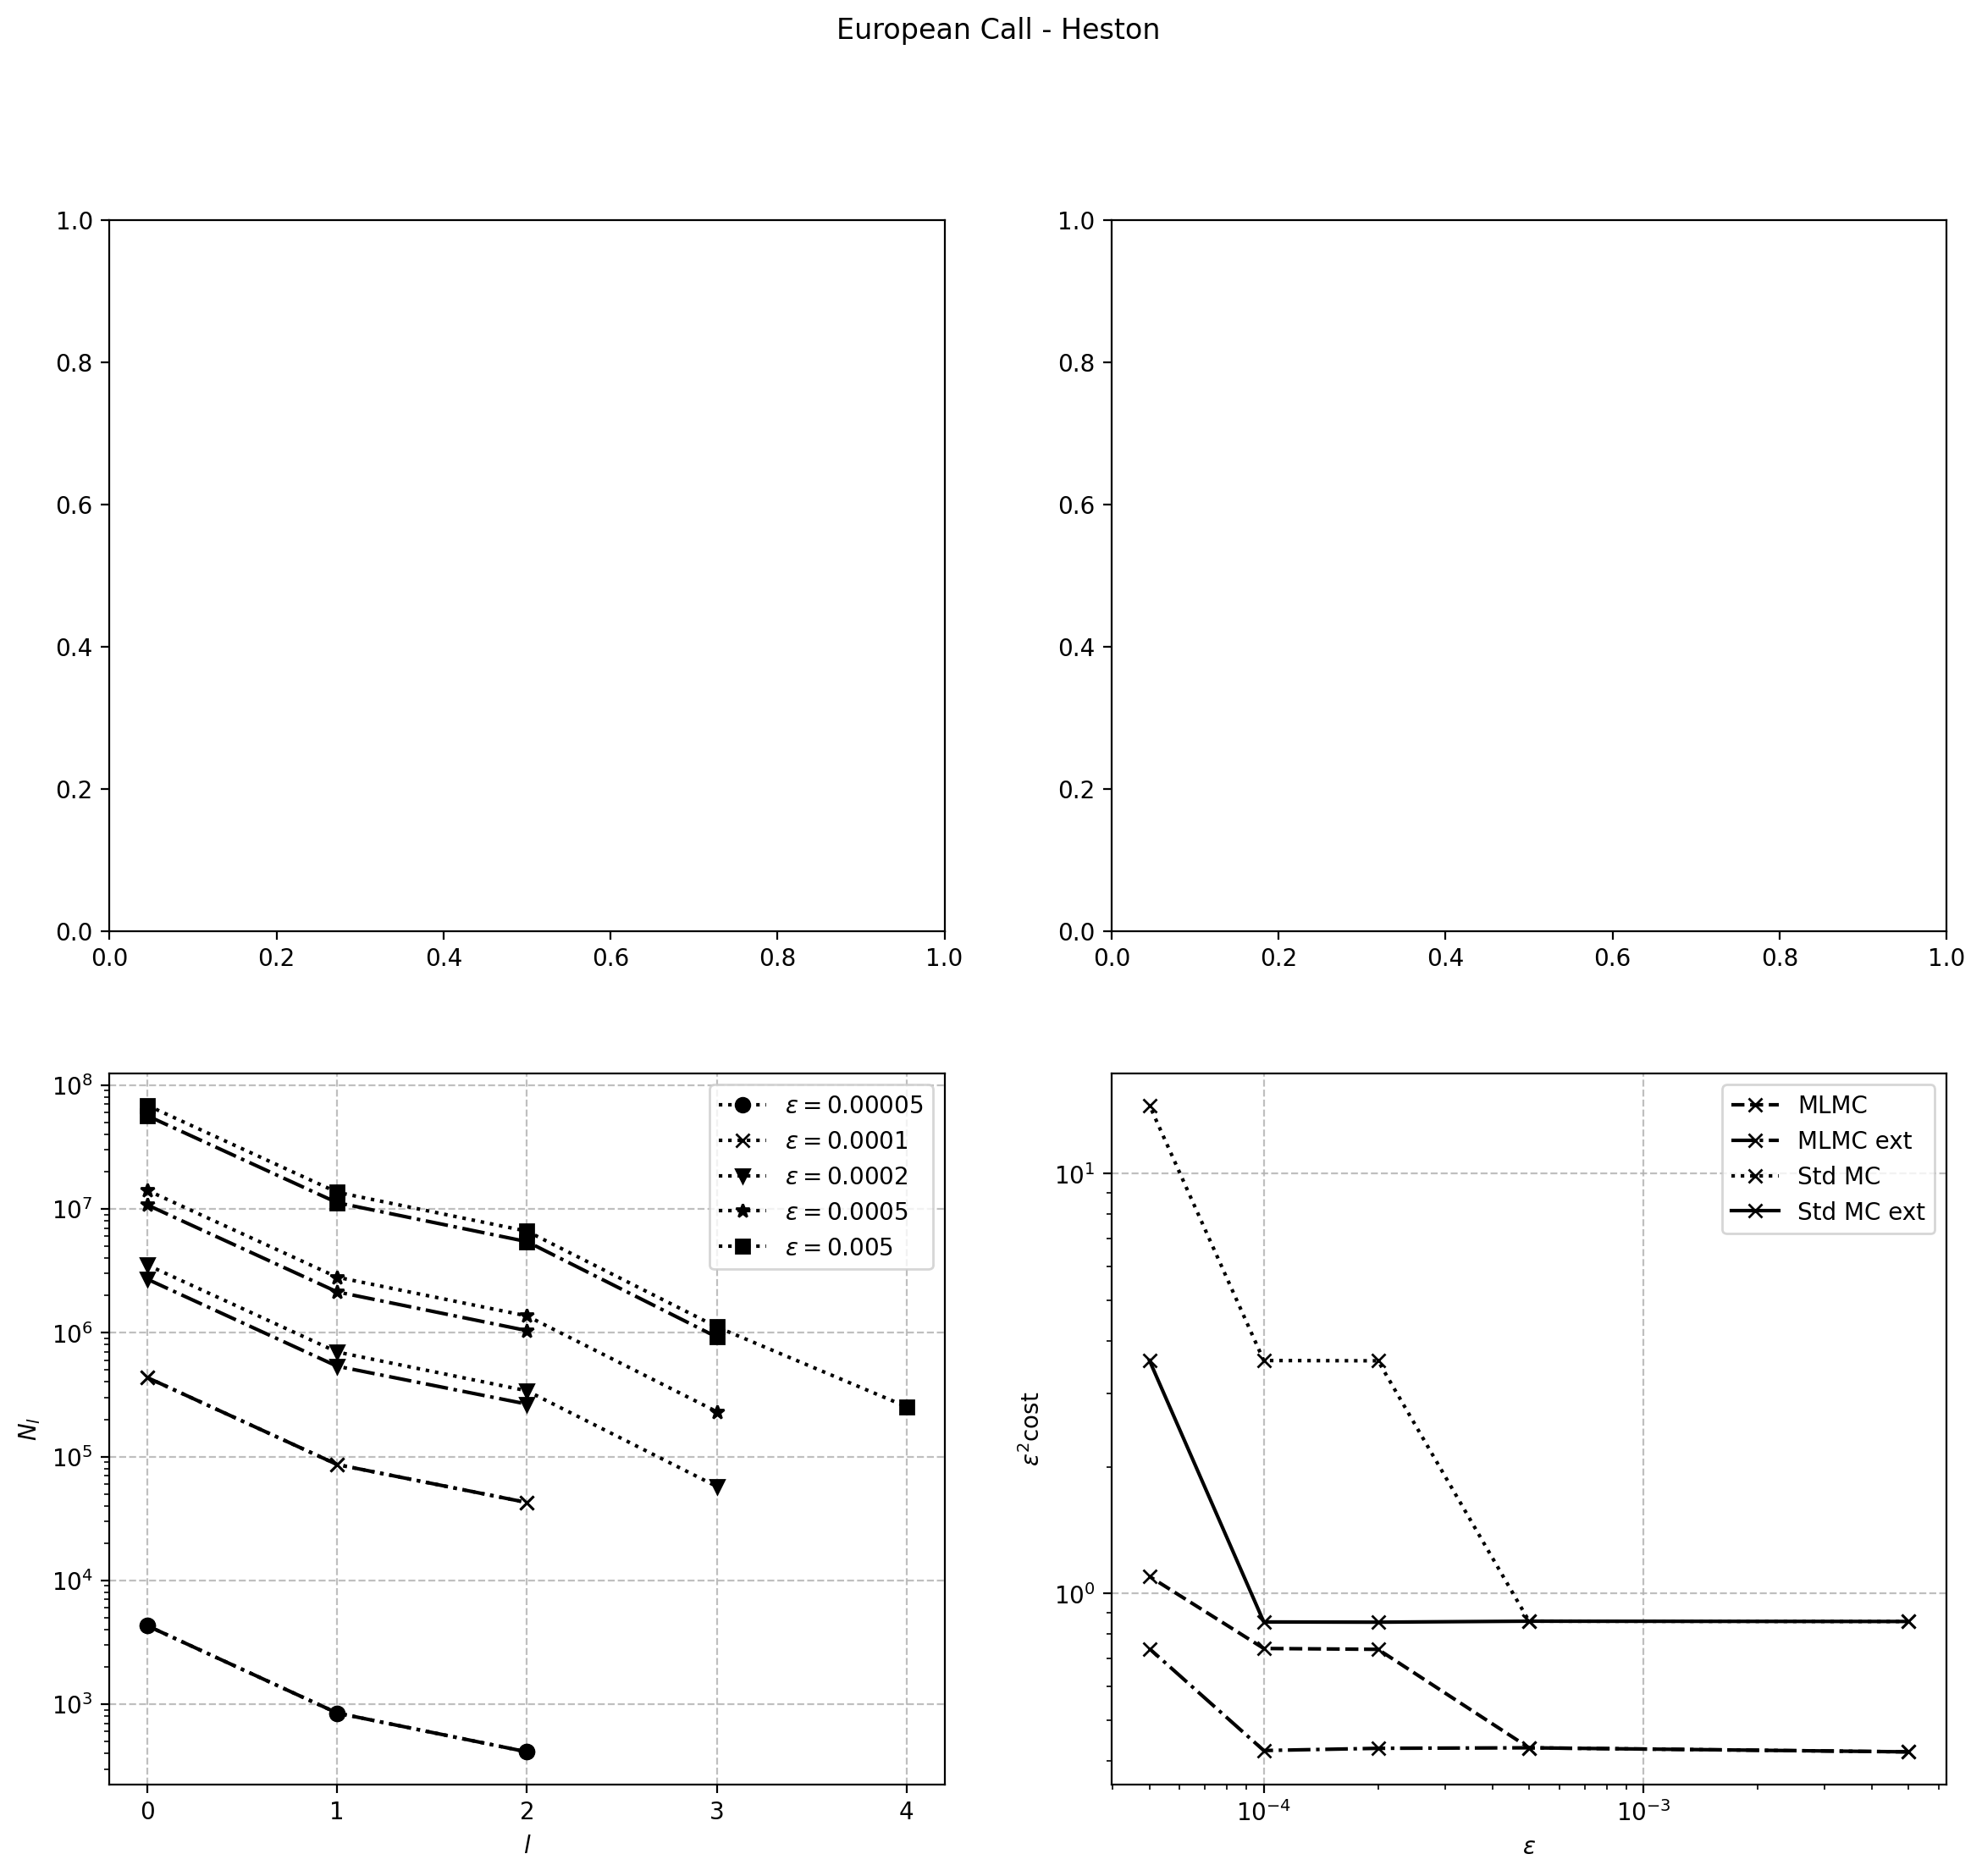

In [7]:
targets_errors = np.array(
    [
        [0.001, 0.0005, 0.0002, 0.0001, 0.00005],
        [0.001, 0.0005, 0.0002, 0.0001, 0.00005],
        [0.002, 0.001, 0.0005, 0.0002, 0.0001],
        [0.005, 0.002, 0.001, 0.0005, 0.0002],
        [0.005, 0.0005, 0.0002, 0.0001, 0.00005],
    ]
)
models = [bs, bs, bs, bs, heston]
contracts = [eu_call, asian_call, lookback, digital, eu_call]

plots = []  # If needed to save the plots
for i, (target_errors, model, contract) in enumerate(zip(targets_errors, models, contracts)):
    mlmc.max_level = 4 if isinstance(contract, Digital) else 5
    plots.append(create_paper_plots(mlmc, model, contract, target_errors))

plt.show()

In [6]:
# Removing memory buffer
# os.remove(gg.filename)
# del gg